# Setup

Our first step is to import packages.

In [1]:
# various utilities
import sys, os, multiprocessing
from functools import reduce
from array import array
import gzip
import pickle

# minhash-related utilities
from mashingpumpkins import _murmurhash3
from mashingpumpkins.minhashsketch import MinSketch
from mashingpumpkins.parallel import Sketch
from mashingpumpkins.sequence import chunkpos_iter
import mashingpumpkins.sourmash

# FASTA reader
import ngs_plumbing.fasta

# Numpy matrix to store dissimilarity between genomes
import numpy

# Progress bar in the notebook
from ipywidgets import FloatProgress
from IPython.display import display

We define a function to chunk assembled genomes (and take advantage of
a multi-core hardware by performing a parallel computation of sketches).

# Demonstration through implementation

We also write a custom hashing function, implementing the idea that "canonical" sketches could be replaced by
the bottom sketch for kmers obtained for the two strands of a double-stranded genomic entity.

We first implement a function that chunks input sequences, optionally yielding the reverse-complement in
addition to the direct strand.

In [2]:
def reads_in_chunks(reader, chunksize, nsize, rc=False):
    """
    reader: reader of FASTA sequences
    chunksize: size of sequence chunks
    nsize: kmer size
    rc: also yield the reverse complement ?
    """
    for n, record in enumerate(reader, 1):
        lseq = len(record.sequence)
        for beg, end in chunkpos_iter(nsize, lseq, chunksize):
            yield record.sequence[beg:end]
            if rc:
                yield mashingpumpkins.sourmash.revcomp(record.sequence[beg:end])

With that function, implementing the building of the two types of sketches to compare is straightforward. The two types are:

<dl>
 <dt>"Canonical"</dt>
 <dd>MASH's way - only the smallest between a kmer and its reverse-complement when sorted by lexicographic order considered for inclusion in a sketch</dd>
 <dt>"Double-stranded"</dt>
 <dd>The bottom sketch of k-mers obtained from both the direct strand and it reverse complement</dd>
</dl>

This allows us to use either MASH's "canonical" hashing in `mashingpumpkins.sourmash.mash_hashfun` (with `rc=False` when calling `reads_in_chunks`) or a vanilla `murmurhash3.hasharray` with `rc=True` when calling `reads_in_chunks` (in which case we obtain our "double-stranded" sketch).

## Empirical demonstration on data

To demonstrate our point, we use a directory with a collection of 200 bacterial genomes in FASTA format
(gzip-compressed) and we build bottom (minhash) sketches of size 1000 for kmers of length 31.

In [3]:
# Increase this if your computer has plenty of cores
ncpu = 3

maxsize = 1000
ksize = 31
seed = 42

fbufsize = int(7E5)
chunksize = int(5E5)

# directory with genomes (as ".fa.gz" files)
directory = "../../dnasnout_reboot/ensembl/release-34/"
filenames = os.listdir(directory)
filenames = tuple(x for x in filenames if x.endswith(".fa.gz"))

Building the sketches is the same across hashing strategies, so we make the hashing strategy a parameter
in a sequence to be looped over. Building the 200 sketches for each hashing strategy should only take a minute (or less). 

In [4]:
# results
res = list()

f = FloatProgress(min=0, max=len(filenames))
display(f) # display the bar

# loop over the two hashing strategies for double-stranded entities we want to compare
for hashfun, rc in ((mashingpumpkins.sourmash.mash_hashfun, False),
                    (_murmurhash3.hasharray, True)):
    # list of results for the current hashing strategy
    res_mhs = list()
    
    # loop over the filenames
    for fn_i, fn in enumerate(filenames, 1):

        f.value += 1
        # process a reference in a FASTA file (well, gzip-compressed FASTA)
        with open(os.path.join(directory, fn), mode='rb', buffering=fbufsize) as fh:
            if fn.endswith('.gz'):
                fh = gzip.open(fh)

            # FASTA reader (iterator over entries in the file)
            reader = ngs_plumbing.fasta.read_fasta(fh)

            # create a pool of processes to build the sketch
            p = multiprocessing.Pool(ncpu-1, # one cpu will be used by this process (the parent)
                                     initializer=Sketch.initializer,
                                     initargs=(MinSketch, ksize, maxsize,
                                               hashfun, seed))
            try:
                result = p.imap_unordered(Sketch.map_sequence,
                                          reads_in_chunks(reader, chunksize, ksize, rc=rc))
                mhs_mp = reduce(Sketch.reduce, result, MinSketch(ksize, maxsize, hashfun, seed))
                res_mhs.append((fn, mhs_mp))
            finally:
                p.terminate()
                
    # append the result for the current hashing strategy
    res.append(res_mhs)

The sketches can then be "frozen" (a more memory-efficient class in `mashingpumpinks`) and Jaccard's similarity
index between pairs of sketches be computed for each one of out hashing strategies.

In [5]:
resf = tuple(tuple((fn, x.freeze()) for fn, x in res_mhs) for res_mhs in res)

import numpy
m_can = numpy.ones([len(filenames), ]*2)
m_ds = numpy.ones([len(filenames), ]*2)

f = FloatProgress(min=0, max=len(filenames))
display(f) # display the bar

for x_i in range(len(filenames)):
    f.value += 1
    for x_j in range(0, x_i):
        for m, idx in ((m_can, 0), (m_ds, 1)):
            x_a = resf[idx][x_i][1]
            x_b = resf[idx][x_j][1]
            d = x_a.jaccard_similarity(x_b)
            m[x_i, x_j] = d
            m[x_j, x_i] = d

R is quite handy for manipulating and plotting data in tables. We use it.

In [12]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Our two matrices with pairwise similiarity measures (two matrices, one per hashing strategy),
are transformed into a grand table to let us plot the similarity measure obtained with one strategy
against the measure obtained with the other strategy.

In [16]:
%%R -i m_can -i m_ds -o dataf

dataf <- dplyr::filter(merge(reshape2::melt(m_can),
                      reshape2::melt(m_ds),
                      by = c("Var1", "Var2")),
                      Var1 < Var2)

In [17]:
from rpy2.ipython import ggplot
from rpy2.robjects.vectors import StrVector
from IPython import display
ggp = ggplot.ggplot2

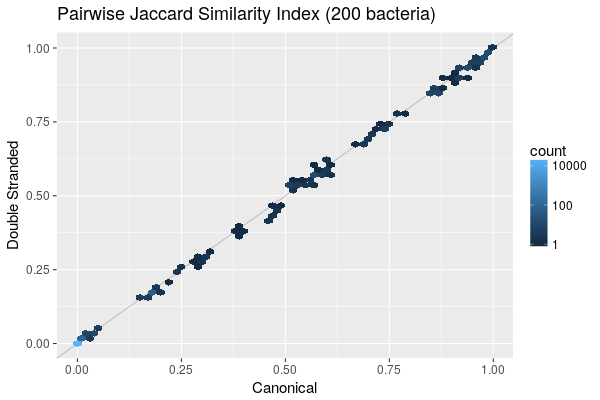

In [18]:
from rpy2.robjects import globalenv
dataf = globalenv['dataf']
p = (ggp.ggplot(dataf) +
     ggp.geom_abline(slope=1, intercept=0, color="grey") +
     ggp.geom_hex(ggp.aes_string(x="value.x", y="value.y"),
                 bins=50) +
     ggp.ggtitle("Pairwise Jaccard Similarity Index (%i bacteria)" % len(filenames)) +
     ggp.scale_x_continuous("Canonical") +
     ggp.scale_y_continuous("Double Stranded") +
     ggp.scale_fill_continuous(trans="log10") +
     ggp.theme_gray(base_size=15))

ggplot.image_png(p, width=600, height=400)

The two strategies appear to give **very** comparable results, with the conceptual advantage that the double
stranded one would allow a seamless integration with the single stranded world (e.g., RNA molecules).

# Some more analysis

Since we have build pairwise similarity for our bacteria, we may as well have a quick look at the structure of these similarities.

Multi-dimensional scaling (here Sammon's mapping) can be used to embbed items defined by their relative dissimilarity to one an other into a cartesian coordinate plane.

In [19]:
%%R -i m_ds -o dataf_sp

library(MASS)
d <- as.dist(1-m_ds)
sp <- sammon(d, y = cmdscale(jitter(d, 2)))
dataf_sp <- data.frame(x = sp$points[,1], y = sp$points[,2])

Initial stress        : 0.76592
stress after  10 iters: 0.49014, magic = 0.092
stress after  20 iters: 0.30996, magic = 0.043
stress after  30 iters: 0.19981, magic = 0.491
stress after  40 iters: 0.18329, magic = 0.045
stress after  40 iters: 0.18329


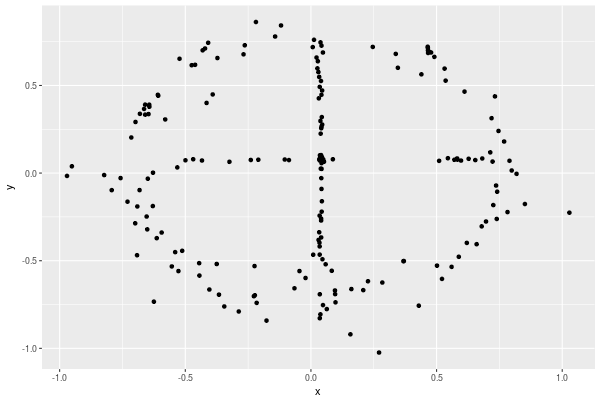

In [20]:
p = (ggp.ggplot(dataf_sp) +
     ggp.geom_point(ggp.aes_string(x="x", y="y")))

ggplot.image_png(p, width=600, height=400)

We can look at where the species for which we have the most entries are in the embedding.

In [21]:
from rpy2.robjects.packages import importr
base = importr('base')
dataf_plot = base.cbind(dataf_sp,
                        name=StrVector(filenames),
                        species=base.I(StrVector([' '.join(x.split('_')[:1]) for x in filenames])))

from collections import Counter
ct = Counter(dataf_plot.rx2('species'))
s = set(x[0] for x in ct.most_common(10))

from rpy2.robjects.vectors import BoolVector
dataf_plot = base.cbind(dataf_plot,
                        many = BoolVector([x in s for x in dataf_plot.rx2('species')]))

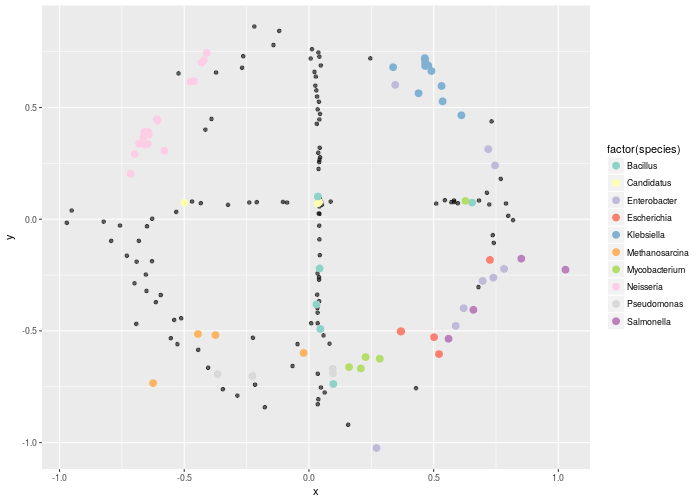

In [30]:
from rpy2.robjects.lib import dplyr
from rpy2.robjects import NULL
p = (ggp.ggplot(dataf_plot) +
     ggp.geom_point(ggp.aes_string(x="x", y="y"), color="black", alpha=.6) +
     ggp.geom_point(ggp.aes_string(x="x", y="y", color='factor(species)'), size=3,
                    data = dplyr.DataFrame(dataf_plot).filter('many')) +
     ggp.scale_color_brewer(palette="Set3")
    )

ggplot.image_png(p, width=700, height=500)

Interesting layout. The "cluster" in the middle, near the coordinates (0,0), is:

In [34]:
tuple(dplyr.DataFrame(dataf_plot).filter('x > 0', 'x < .1',
                                                   'y > 0', 'y < .1').rx2('species'))

('Enterococcus',
 'Helicobacter',
 'Synechocystis',
 'Candidatus',
 'Peptoclostridium',
 'Nostoc',
 'Mycoplasma',
 'Haloarcula',
 'Candidatus',
 'Staphylococcus',
 'Wolbachia',
 'Ralstonia',
 'Photobacterium',
 'Prevotella',
 'Francisella',
 'Sinorhizobium',
 'Brevibacillus',
 'Treponema',
 'Lactococcus',
 'Brucella',
 'Bradyrhizobium',
 'Mesoplasma',
 'Natronomonas')